# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.867880,False,-1.213537
1,-2.046701,True,3.201041
2,0.750621,True,6.472341
3,-1.246989,True,2.327949
4,-0.819353,False,-2.502402
...,...,...,...
995,0.523252,False,-0.207875
996,-0.329161,False,-0.585180
997,-1.867915,False,-4.556996
998,0.321734,False,1.469323


<AxesSubplot: xlabel='v0'>

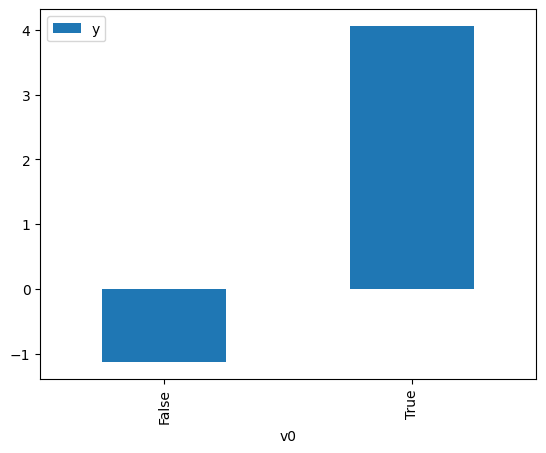

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

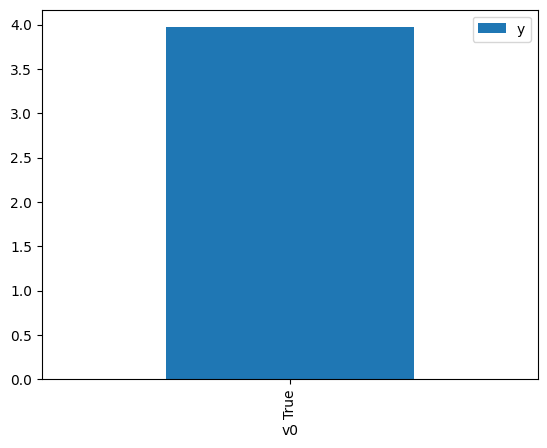

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.137521,False,-3.435970,0.513067,1.949061
1,-1.705167,False,-3.502448,0.538457,1.857158
2,0.459286,False,1.061002,0.441709,2.263935
3,-3.387012,False,-7.497455,0.612042,1.633875
4,0.295381,False,1.096117,0.448973,2.227305
...,...,...,...,...,...
995,-1.227666,False,-0.467075,0.517107,1.933834
996,-0.391565,False,0.879484,0.479620,2.084982
997,-0.810002,False,-0.138623,0.498379,2.006505
998,0.725354,False,1.341801,0.429971,2.325739


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.085707,True,4.980003,0.541703,1.846031
1,-1.731841,True,1.363895,0.460354,2.172243
2,-0.664555,True,3.858560,0.508145,1.967943
3,-0.911131,True,4.903659,0.497085,2.011729
4,-0.514285,True,4.953139,0.514882,1.942194
...,...,...,...,...,...
995,-2.515339,True,1.812379,0.425680,2.349185
996,2.197854,True,9.068542,0.633248,1.579159
997,1.454272,True,7.895846,0.601749,1.661822
998,0.151752,True,5.532625,0.544643,1.836064


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.927
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                              6360.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):                        0.00
Time:                        13:51:10   Log-Likelihood:                         -1432.5
No. Observations:                1000   AIC:                                      2869.
Df Residuals:                     998   BIC:                                      2879.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9067      0.030     64.158      0.000       1.848       1.965
x2             5.0010      0.047    107.147      0.000       4.909       5.093
==============================================================================
Omnibus:                        1.102   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                1.131
Skew:                           0.020   Prob(JB):                        0.568
Kurtosis:                       2.840   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""